In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [2]:
import sympy as sp
import numba
from numba import jit, generated_jit
from sympy import lambdify
from sympy.abc import x,y,z
from sympy.utilities.lambdify import lambdastr
from sympy.utilities.autowrap import ufuncify, autowrap
from sympy.printing.theanocode import theano_function
import numpy
from sympy.printing.pycode import NumPyPrinter as Printer
from Cython.Build import cythonize
from sympy.utilities.codegen import *
import pickle
import subprocess
import os
import matplotlib.pyplot as plt
import pylab
from collections import defaultdict, OrderedDict
import tensorflow as tf

In [3]:
def generate_functions(fn, variables):
    lambda_npprinter = eval(lambdastr(variables, fn, printer=Printer))
    fns_dict = OrderedDict(tf_lambdify=lambdify(variables, fn, "tensorflow"),
                           unfunc_numpy=ufuncify(variables, fn),
                           ufunc_cython=ufuncify(variables, *fn, backend='Cython'),
                           ufunc_f2py=ufuncify(variables, *fn, backend='f2py'),
                           theano=theano_function(variables, fn, on_unused_input='ignore', dims=dict(zip(*(variables, [1]*4)))),
                           lambdify=lambdify(variables, fn),
                           numba=jit(lambda_npprinter))
    return fns_dict

def timeit(fn, fn_name, data):
    setup_data=[dat*2 for dat in data]
    if fn_name=="tf_lambdify":
        data=[tf.convert_to_tensor(dat) for dat in data]
        setup_data=[tf.convert_to_tensor(dat) for dat in setup_data]
        setup_output=fn(setup_data[0], setup_data[1], setup_data[2], setup_data[3])
        output=fn(data[0], data[1], data[2], data[3])
        with tf.Session() as sess:
            sess.run(setup_output)
            fn_timed = %timeit -n 100 -o sess.run(output)
    else:
        fn(setup_data[0], setup_data[1], setup_data[2], setup_data[3])
        fn_timed = %timeit -n 100 -o fn(data[0], data[1], data[2], data[3])
    return numpy.average(fn_timed.timings)*100000

def time_fns(fns, input_data):
    timings = defaultdict(list)
    for fn_name in fns:
        for data in input_data:
            timings[fn_name].append(timeit(fns[fn_name], fn_name, data))
    return timings

def plot_timings(fns, timings, name_plot):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.subplot()
    for fn in fns:
        plt.loglog(batchsizes, timings[fn], label=fn, basex=10)
    plt.legend(fns)
    plt.title(name_plot)
    plt.xlabel('batchsize')
    plt.ylabel('time [microseconds]')

    pylab.show()
    fig.savefig(name_plot)

In [4]:
batchsizes = [1, 5, 10, 100, 500, 1000, 2000, 4000, 10000]
input_data = [[numpy.linspace(1.0, 100.0, num=batchsize)]*4 for batchsize in batchsizes]

In [5]:
x_1, x_2, x_3, x_4 = sp.symbols(['x_{}'.format(i + 1) for i in range(4)], real=True)
variables = [x_1,x_2,x_3,x_4]
f = [(-1.45393490791321*sp.cos(1.58377933502197*x_2) + 1.1714084148407*sp.cos(1.57067489624023*x_4))/(-2.68741791611482*x_3 + 2.14890541716684)]
g = [(0.330951620314678*x_1 + 0.251283871374747*x_2 - 0.000764998943063247*x_3 + 0.586457312107086*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) + 0.0277242679148912*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) + 0.0707238242030144*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.847072184085846*sp.cos(0.567299902439117*x_4) - 0.462350964546204*sp.cos(0.936475217342377*x_1 + 0.91965651512146*x_2) + 0.298887223005295*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.00118042330723256*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) + 0.498127937316895*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 0.586544187035779)/(0.00356105187778347*x_1*(0.215010732412338*x_1 + 0.114812202751637) + 0.00121608858307276*x_1*(0.0198317039757967*x_2 - 0.105209961533546) + 0.303592865970725*x_1 + 0.000390869741989288*x_2*(0.629352807998657*x_1 + 0.0899656191468239*x_2) + 0.247990016664015*x_2 + 0.0357437724664018*x_3 + 0.070805549621582*sp.sin(1.22932803630829*x_1 - 0.0663360953330994) - 0.194963961839676*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) - 0.0904307141900063*sp.sin(0.228799387812614*x_2 + 0.00568674551323056*x_3 + 0.151351436972618) + 0.469951987266541*sp.sin(1.11081087589264*x_3 - 0.000472099316539243*x_4 + 0.118964143097401) + 0.415509521961212*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) - 0.231957778334618*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.185390949249268*sp.sin(0.533309817314148*x_1 - 0.0208132732659578*x_3 + 7.80451591708697e-5*x_4 + 0.0470873974263668) + 0.0763821750879288*sp.sin(0.655102789402008*x_1 + 0.209421753883362*x_2 - 0.098652184009552*x_4 - 0.0803295373916626) + 0.400588274002075*sp.sin(0.0760507732629776*x_1 - 0.198078081011772*x_2 - 0.153881505131721*x_3 + 0.323018699884415*x_4 + 0.078629694879055) - 0.575652480125427*sp.sin(0.151428386569023*x_1 + 0.0854837000370026*x_2 + 0.0829992443323135*x_3 + 0.129805728793144*x_4 - 0.510312259197235) + 0.335055708885193*sp.cos(0.567299902439117*x_4) + 1.28572380542755*sp.cos(0.588990449905396*x_1 - 0.223206877708435) - 0.770835280418396*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.682210683822632*sp.cos(0.126800462603569*x_1 + 0.032390333712101*x_2 + 0.0171887408941984*x_3 + 0.0635184124112129*x_4) + 1.00636518001556*sp.cos(0.196726188063622*x_1 - 0.00108204141724855*x_2 - 0.018897108733654*x_3 + 0.0260542128235102) - 0.10939959436655*sp.cos(0.401220709085464*x_1 - 0.452930152416229*x_2 - 0.197876781225204*x_3 + 0.402657061815262*x_4) - 0.409356415271759*sp.cos(1.12020909786224*x_1 - 0.0272857788950205*x_3 + 0.037493173032999*x_4 + 0.400413155555725) - 0.260538846254349*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) - 0.39827623963356*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 2.84273435561502)]
h = [sp.cos(sp.sin((0.330951620314678*x_1 + 0.251283871374747*x_2 - 0.000764998943063247*x_3 + 0.586457312107086*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) + 0.0277242679148912*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) + 0.0707238242030144*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.847072184085846*sp.cos(0.567299902439117*x_4) - 0.462350964546204*sp.cos(0.936475217342377*x_1 + 0.91965651512146*x_2) + 0.298887223005295*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.00118042330723256*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) + 0.498127937316895*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 0.586544187035779)/(0.00356105187778347*x_1*(0.215010732412338*x_1 + 0.114812202751637) + 0.00121608858307276*x_1*(0.0198317039757967*x_2 - 0.105209961533546) + 0.303592865970725*x_1 + 0.000390869741989288*x_2*(0.629352807998657*x_1 + 0.0899656191468239*x_2) + 0.247990016664015*x_2 + 0.0357437724664018*x_3 + 0.070805549621582*sp.sin(1.22932803630829*x_1 - 0.0663360953330994) - 0.194963961839676*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) - 0.0904307141900063*sp.sin(0.228799387812614*x_2 + 0.00568674551323056*x_3 + 0.151351436972618) + 0.469951987266541*sp.sin(1.11081087589264*x_3 - 0.000472099316539243*x_4 + 0.118964143097401) + 0.415509521961212*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) - 0.231957778334618*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.185390949249268*sp.sin(0.533309817314148*x_1 - 0.0208132732659578*x_3 + 7.80451591708697e-5*x_4 + 0.0470873974263668) + 0.0763821750879288*sp.sin(0.655102789402008*x_1 + 0.209421753883362*x_2 - 0.098652184009552*x_4 - 0.0803295373916626) + 0.400588274002075*sp.sin(0.0760507732629776*x_1 - 0.198078081011772*x_2 - 0.153881505131721*x_3 + 0.323018699884415*x_4 + 0.078629694879055) - 0.575652480125427*sp.sin(0.151428386569023*x_1 + 0.0854837000370026*x_2 + 0.0829992443323135*x_3 + 0.129805728793144*x_4 - 0.510312259197235) + 0.335055708885193*sp.cos(0.567299902439117*x_4) + 1.28572380542755*sp.cos(0.588990449905396*x_1 - 0.223206877708435) - 0.770835280418396*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.682210683822632*sp.cos(0.126800462603569*x_1 + 0.032390333712101*x_2 + 0.0171887408941984*x_3 + 0.0635184124112129*x_4) + 1.00636518001556*sp.cos(0.196726188063622*x_1 - 0.00108204141724855*x_2 - 0.018897108733654*x_3 + 0.0260542128235102) - 0.10939959436655*sp.cos(0.401220709085464*x_1 - 0.452930152416229*x_2 - 0.197876781225204*x_3 + 0.402657061815262*x_4) - 0.409356415271759*sp.cos(1.12020909786224*x_1 - 0.0272857788950205*x_3 + 0.037493173032999*x_4 + 0.400413155555725) - 0.260538846254349*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) - 0.39827623963356*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 2.84273435561502))+sp.cos((0.330951620314678*x_1 + 0.251283871374747*x_2 - 0.000764998943063247*x_3 + 0.586457312107086*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) + 0.0277242679148912*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) + 0.0707238242030144*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.847072184085846*sp.cos(0.567299902439117*x_4) - 0.462350964546204*sp.cos(0.936475217342377*x_1 + 0.91965651512146*x_2) + 0.298887223005295*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.00118042330723256*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) + 0.498127937316895*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 0.586544187035779)/(0.00356105187778347*x_1*(0.215010732412338*x_1 + 0.114812202751637) + 0.00121608858307276*x_1*(0.0198317039757967*x_2 - 0.105209961533546) + 0.303592865970725*x_1 + 0.000390869741989288*x_2*(0.629352807998657*x_1 + 0.0899656191468239*x_2) + 0.247990016664015*x_2 + 0.0357437724664018*x_3 + 0.070805549621582*sp.sin(1.22932803630829*x_1 - 0.0663360953330994) - 0.194963961839676*sp.sin(0.695542991161346*x_1 + 0.033497516065836*x_3 - 0.12209777534008) - 0.0904307141900063*sp.sin(0.228799387812614*x_2 + 0.00568674551323056*x_3 + 0.151351436972618) + 0.469951987266541*sp.sin(1.11081087589264*x_3 - 0.000472099316539243*x_4 + 0.118964143097401) + 0.415509521961212*sp.sin(0.0969495549798012*x_1 - 0.159007877111435*x_2 - 0.0244113598018885*x_3 + 0.454225838184357) - 0.231957778334618*sp.sin(0.195948481559753*x_1 - 0.241881683468819*x_2 - 0.000448446720838547*x_3 + 0.0517358481884003) - 0.185390949249268*sp.sin(0.533309817314148*x_1 - 0.0208132732659578*x_3 + 7.80451591708697e-5*x_4 + 0.0470873974263668) + 0.0763821750879288*sp.sin(0.655102789402008*x_1 + 0.209421753883362*x_2 - 0.098652184009552*x_4 - 0.0803295373916626) + 0.400588274002075*sp.sin(0.0760507732629776*x_1 - 0.198078081011772*x_2 - 0.153881505131721*x_3 + 0.323018699884415*x_4 + 0.078629694879055) - 0.575652480125427*sp.sin(0.151428386569023*x_1 + 0.0854837000370026*x_2 + 0.0829992443323135*x_3 + 0.129805728793144*x_4 - 0.510312259197235) + 0.335055708885193*sp.cos(0.567299902439117*x_4) + 1.28572380542755*sp.cos(0.588990449905396*x_1 - 0.223206877708435) - 0.770835280418396*sp.cos(-1.51749408245087*x_1 + 0.00899437069892883*x_2 + 0.584320902824402) + 0.682210683822632*sp.cos(0.126800462603569*x_1 + 0.032390333712101*x_2 + 0.0171887408941984*x_3 + 0.0635184124112129*x_4) + 1.00636518001556*sp.cos(0.196726188063622*x_1 - 0.00108204141724855*x_2 - 0.018897108733654*x_3 + 0.0260542128235102) - 0.10939959436655*sp.cos(0.401220709085464*x_1 - 0.452930152416229*x_2 - 0.197876781225204*x_3 + 0.402657061815262*x_4) - 0.409356415271759*sp.cos(1.12020909786224*x_1 - 0.0272857788950205*x_3 + 0.037493173032999*x_4 + 0.400413155555725) - 0.260538846254349*sp.cos(0.25383722782135*x_2 + 0.126776129007339*x_3 - 0.0631546676158905*x_4 - 0.931427180767059) - 0.39827623963356*sp.cos(0.607544362545013*x_1 + 0.208046942949295*x_2 + 0.0272154696285725*x_3 + 0.148081555962563*x_4 - 0.207789659500122) + 2.84273435561502)))]

In [6]:
f_fns = generate_functions(f, variables)
g_fns = generate_functions(g, variables)
h_fns = generate_functions(h, variables)

In [7]:
ftimings = time_fns(f_fns, input_data)
gtimings = time_fns(g_fns, input_data)
htimings = time_fns(h_fns, input_data)

10.1 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.5 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.2 µs ± 6.21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.7 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
41.8 µs ± 5.41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.5 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
111 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
288 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.3 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16 µs ± 66.5 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.3 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.5 µs ± 507 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
66.3 µs ± 503 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
1

10.1 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.3 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.4 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.8 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
131 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
529 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.09 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.07 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.08 ms ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.99 µs ± 58.5 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.14 µs ± 80.1 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.63 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.9 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)

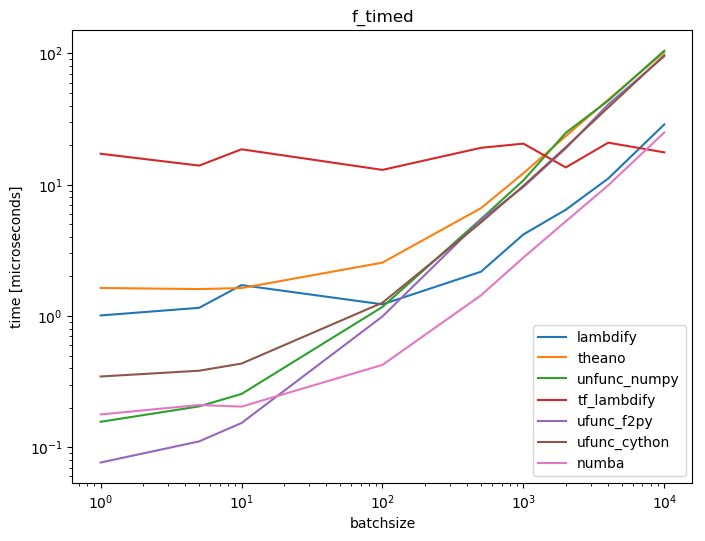

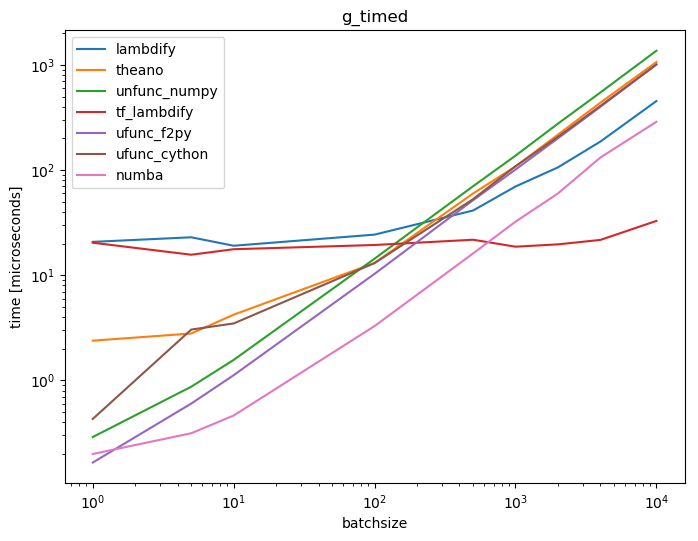

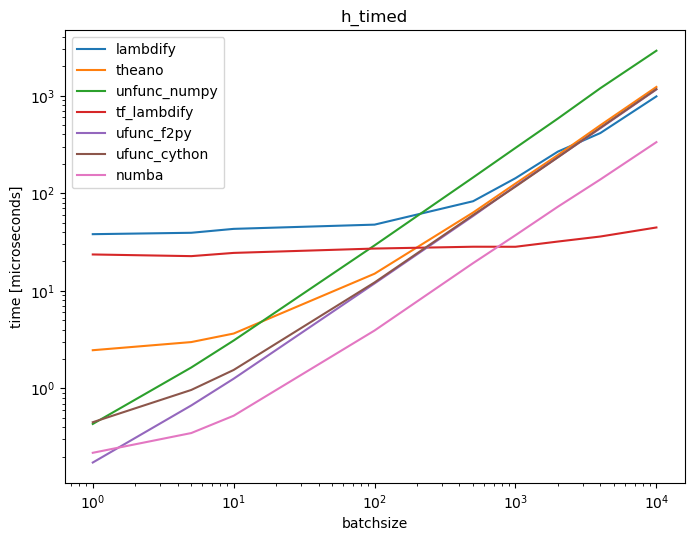

In [8]:
plot_timings(f_fns.keys(), ftimings, 'f_timed')
plot_timings(g_fns.keys(), gtimings, 'g_timed')
plot_timings(h_fns.keys(), htimings, 'h_timed')


It is quite obvious that for our use-case (batch sizes 500-1000, harder functions than f) the numba approach is the best.